# NLP Standard Project 
Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:
Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [41]:
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

#bert model
import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset


#metrics
from sklearn.metrics import classification_report, f1_score

## Data Loading

Load the JSON in a Pandas Dataframe

In [50]:
file_path_train = 'Data/Task C/MELD_train_efr.json'
df = pd.read_json(file_path_train)

df_train = pd.read_json(file_path_train)

df_train.shape

(4000, 5)

In [3]:
df_train.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


Drop episode column since it is only an index and it is not useful for the task

In [4]:
df = df_train.drop(columns=['episode'])
print(f"Dataframe shape after dropping column: {df.shape}")
df.head()

Dataframe shape after dropping column: (4000, 4)


,speakers,emotions,utterances,triggers
0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


## Preprocessing

### NaN values
Some trigger labels are not correctly formatted and appear as NaN -> we convert them to zero to avoid errors.

In [5]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [6]:
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [7]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


### Split data 
80/10/10 train/val/test split

In [8]:
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 4)
Test shape: (400, 4)
Val shape: (400, 4)


In [130]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [ ]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [ ]:
print(f"Il discorso continua fino all'utterance numero 3205")
print(f"Dialogue: {df_test['utterances'][3205]}")

il discorso continua fino all'utterance numero 3205
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this p

In [ ]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [ ]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


Effettivamente pare che il discorso venga splittato in due tra train e test però il prof specifica nelle raccomandazioni: "Given the dataset format, this property should be trivially guaranteed." 

Dal forum: "According to the instructions, you are free to perform data splitting as you prefer and motivate your decision accordingly.
In other words, there is no explicit penalization for data splitting.
Note that this doesn't mean that potential issues/consequences are evaluated equally.
Think about what you would do in a real-world scenario.
To sum up, we evaluate your understanding of the problem and your corresponding actions."

In [9]:
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 4)
Test shape: (397, 4)
Val shape: (398, 4)


In [136]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [137]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


Ancora un dialogo splittato tra test e val

In [10]:
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [140]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3602]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [141]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


Questa dovrebbe essere la shape dei dataset

In [11]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 4)
Test shape: (398, 4)
Val shape: (397, 4)


### Split every sentence in the dfs

In [12]:
def split_utterances(df):
    speakers_list = []
    utterances_list = []
    emotions_list = []
    trigger_list = []

    #Itera su ogni riga del dataframe originale
    for index, row in df.iterrows():
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']
        
        # Itera su ogni frase nell'array 'utterances'
        for i in range(len(utterances)):
            speakers_list.append(speakers[i])
            utterances_list.append(utterances[i])
            emotions_list.append(emotions[i])
            trigger_list.append(triggers[i])
    
    # Crea un nuovo dataframe dalle liste
    new_df = pd.DataFrame({
        'speaker': speakers_list,
        'utterance': utterances_list,
        'emotion': emotions_list,
        'trigger': trigger_list
    })

    return new_df

In [13]:
df_train_s = split_utterances(df_train)
df_train_s.head(15)

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0
5,Chandler,also I was the point person on my company's tr...,neutral,0.0
6,The Interviewer,You must've had your hands full.,neutral,0.0
7,Chandler,That I did. That I did.,neutral,0.0
8,The Interviewer,So let's talk a little bit about your duties.,neutral,0.0
9,Chandler,My duties? All right.,surprise,0.0


In [14]:
print(df_train_s.iloc[52:69,:])

     speaker                                          utterance   emotion  \
52  Chandler                                          Hey, Mon.   neutral   
53    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
54  Chandler                                         Do I ever.       joy   
55  Chandler                                          Hey, Mon.   neutral   
56    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
57  Chandler                                         Do I ever.       joy   
58    Monica           Chris says they're closing down the bar.   sadness   
59  Chandler                                          Hey, Mon.   neutral   
60    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
61  Chandler                                         Do I ever.       joy   
62    Monica           Chris says they're closing down the bar.   sadness   
63  Chandler                                            No way!  surprise   

Ho notato che i trigger sono a 1.0 nei vari dialoghi *non* nelle stesse frasi. Ad esempio la stessa frase in un dialogo diverso, ha un trigger diverso. Riga 53 e riga 56 hanno la stessa frase ed emozione ma trigger diverso. Stessa cosa frase 63 e 68. 

Comincio a pensare che in realtà bisogna passare tutto il df così come lo si legge dal json.

In [15]:
df_test_s = split_utterances(df_test)

df_val_s = split_utterances(df_val)

### Data distributions
Is the train dataset imbalanced? Verify emotions and triggers

#### Emotions distribution

In [16]:
emotions_counts = {}
for emotions in df_train['emotions']:
    for emotion in emotions:
        if emotion in emotions_counts:
            emotions_counts[emotion] += 1
        else:
            emotions_counts[emotion] = 1

print(emotions_counts)

{'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}


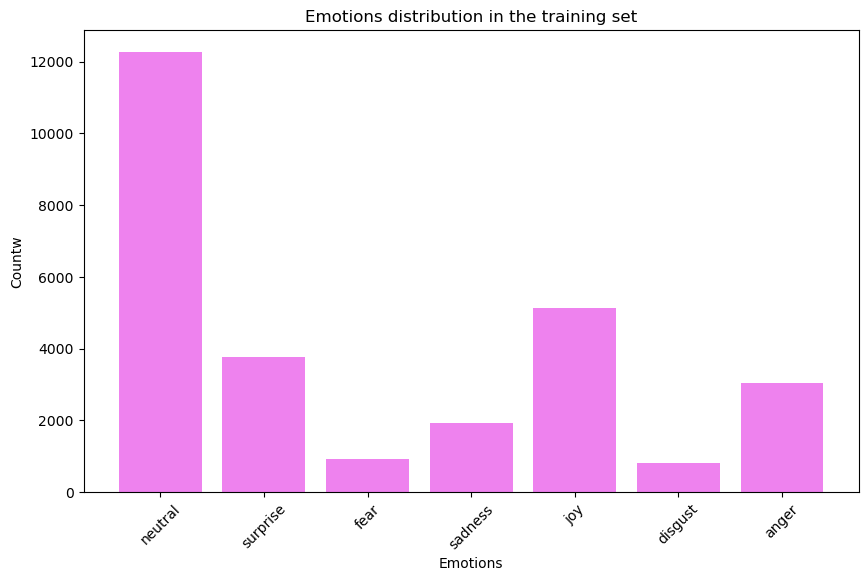

In [17]:
emotions = list(emotions_counts.keys())
emotion_counts = list(emotions_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='violet')
plt.xlabel('Emotions')
plt.ylabel('Countw')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

### Triggers distribution

In [18]:
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


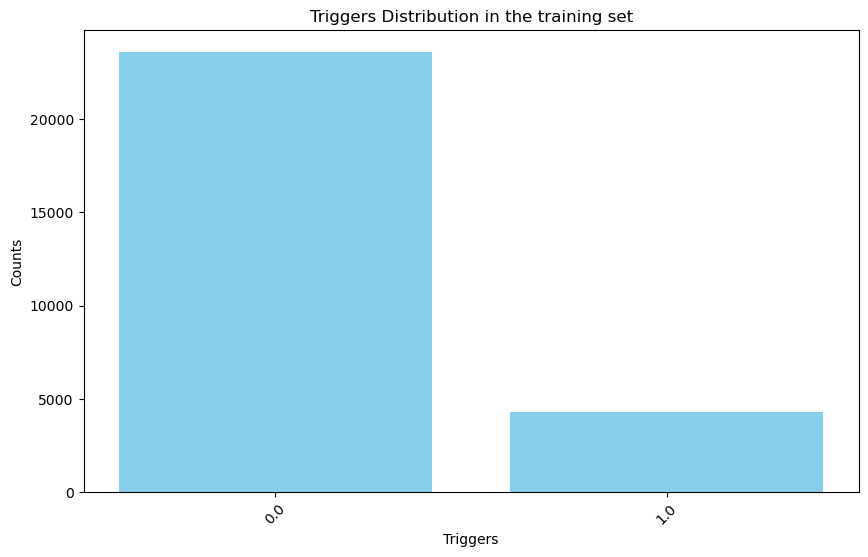

In [19]:
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color='skyblue')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

As we can see both emotions and triggers are highly imbalanced, the emotion with the highest count is 'neutral' and the trigger with the highest count is '0.0'. 

When a class imbalance exists within the training data, machine learning models will typically over-classify the larger classes due to their increased prior probability. As a result, the instances belonging to the smaller class(es) are typically misclassified more often than those belonging to the larger class(es).

How to deal with imbalanced data in classification? https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

Class weights penso sia la strategia migliore da adottare per questo caso

In [20]:
# Calcola i pesi delle classi
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts) * count) for emotion, count in emotions_counts.items()}

print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


Class weights computing using sklearn class_weight='balanced'

In [21]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

#weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

#save in dictionary
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


In [22]:
# Calcolo dei pesi per la colonna 'triggers'
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## Models definition

You should train and evaluate a BERT baseline on two different settings:
     
     - Freezed: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
     - Full: we fine-tune the whole model architecture. 
     
Make sure you set a small enough batch size.  We recommend 1.

We recommend `bert-base-uncased`.

In addition, you should evaluate a random and a majority classifier for emotions and triggers.
You should report a comparison with your selected model(s) and the provided baselines

#### Baseline models 
Defining random and majority dummy classifiers 

In [23]:
random_emotions = DummyClassifier(strategy='uniform', random_state=42)
majority_emotions = DummyClassifier(strategy='most_frequent', random_state=42)

random_triggers = DummyClassifier(strategy='uniform', random_state=42)
majority_triggers = DummyClassifier(strategy='most_frequent', random_state=42)

## Evaluation Metrics

## Training and evaluation

### Fitting baseline models

Comincio a pensare che non è questo il modo di passare i dati al modello, ma forse sarebbe più utile splittare le utterances in un 
singola frase e avere una struttura: (speaker) frase emotion trigger 
speaker direi che è opzionale 

Magari facciamo entrambe e vediamo qual è la performance migliore?

Va ancora fatto l'encoding del dataset

In [24]:
df_train_s.head()

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0


In [25]:
X_train = df_train_s.drop(columns=['emotion', 'trigger'])

y_train_emotions = df_train_s['emotion']
y_train_triggers = df_train_s['trigger']

In [26]:
X_test = df_test_s.drop(columns=['emotion', 'trigger'])

y_test_emotions = df_test_s['emotion']
y_test_triggers = df_test_s['trigger']

Encoding

ho fatto il OneHot Encoding perchè abbiamo a che fare con variabili categoriali nominali che non hanno quindi un ordine intrinseco.

In [27]:
oh_encoder = OneHotEncoder()

#train
X_train_encoded = oh_encoder.fit_transform(X_train).toarray()
y_train_emotions_encoded = oh_encoder.fit_transform(y_train_emotions.values.reshape(-1, 1)).toarray()
# Get the emotions ordered
categories = oh_encoder.categories_[0]
emotion_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

y_train_triggers_encoded = oh_encoder.fit_transform(y_train_triggers.values.reshape(-1, 1)).toarray()
#get the triggers ordered
categories = oh_encoder.categories_[0]
trigger_names = ['0.0', '1.0']

#test
X_test_encoded = oh_encoder.fit_transform(X_test).toarray()
y_test_emotions_encoded = oh_encoder.fit_transform(y_test_emotions.values.reshape(-1, 1)).toarray()
y_test_triggers_encoded = oh_encoder.fit_transform(y_test_triggers.values.reshape(-1, 1)).toarray()

In [28]:
random_emotions.fit(X_train_encoded, y_train_emotions_encoded)
majority_emotions.fit(X_train_encoded, y_train_emotions_encoded)

random_triggers.fit(X_train_encoded, y_train_triggers_encoded)
majority_triggers.fit(X_train_encoded, y_train_triggers_encoded)

DummyClassifier(random_state=42, strategy='most_frequent')

### Evaluating baseline models

In [29]:
y_pred_random_emotions = random_emotions.predict(X_test_encoded)
y_pred_majority_emotions = majority_emotions.predict(X_test_encoded)

y_pred_random_triggers = random_triggers.predict(X_test_encoded)
y_pred_majority_triggers = majority_triggers.predict(X_test_encoded)

In [30]:
#Classification reports 

#emotions
print("Classification report for baseline random clf emotions:")
print(classification_report(y_test_emotions_encoded, y_pred_random_emotions, target_names=emotion_names, zero_division=0))

print("Classification report for baseline majority clf emotions:")
print(classification_report(y_test_emotions_encoded, y_pred_majority_emotions, target_names=emotion_names, zero_division=0))

#triggers
print("Classification report for baseline random clf triggers:")
print(classification_report(y_test_triggers_encoded, y_pred_random_triggers, target_names=trigger_names, zero_division=0))

print("Classification report for baseline majority clf triggers:")
print(classification_report(y_test_triggers_encoded, y_pred_majority_triggers, target_names=trigger_names, zero_division=0))

Classification report for baseline random clf emotions:
              precision    recall  f1-score   support

       anger       0.12      0.48      0.20       455
     disgust       0.03      0.53      0.05        88
        fear       0.03      0.48      0.06       121
         joy       0.16      0.49      0.24       576
     neutral       0.42      0.47      0.44      1505
     sadness       0.08      0.43      0.14       349
    surprise       0.13      0.53      0.21       439

   micro avg       0.14      0.48      0.21      3533
   macro avg       0.14      0.49      0.19      3533
weighted avg       0.25      0.48      0.30      3533
 samples avg       0.14      0.48      0.21      3533

Classification report for baseline majority clf emotions:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       455
     disgust       0.00      0.00      0.00        88
        fear       0.00      0.00      0.00       121
         joy      

### Metrics definition

Ho interpretato le due metriche così:

1. SEQUENCE F1-SCORE - per ogni istanza calcola l'F1-score fra l'array di labels predetto dal modello e l'array cdi true labels (sia per Triggers che per Emotions); poi computa il valor medio fra le istanze del DataFrame;
2. UNROLLED F1-SCORE - opera un flatten di tutte le utterances, che vengono considerate come se facessero parte di un singolo dialogo: viene poi calcolato l'F1-score considerando l'array di tutte le labels predette dal modello per tutte le utterances facenti parte del DataFrame e l'array di tutte le true labels relative a tutte le utterances del DataFrame.

In [ ]:
def compute_metrics(df_with_predictions):
    """
        Compute sequence and unrolled F1-scores for Triggers and Emotions for each dialogue in the DataFrame.

        Input:
            df_with_predictions: DataFrame containing the following columns:
            - 'triggers': list of lists of ground truth trigger labels for each dialogue
            - 'Predicted_Triggers': list of lists of predicted trigger labels for each dialogue
            - 'emotions': list of lists of ground truth emotion labels for each dialogue
            - 'Predicted_Emotions': list of lists of predicted emotion labels for each dialogue

        Output:
            Dictionary containing the following metrics:
            - 'avg_sequence_f1_triggers': average F1-score for Triggers computed at the dialogue level
            - 'avg_sequence_f1_emotions': average F1-score for Emotions computed at the dialogue level
            - 'unrolled_f1_triggers': F1-score for Triggers computed at the utterance level
            - 'unrolled_f1_emotions': F1-score for Emotions computed at the utterance level
    """
    # Initialize lists to store F1-scores for each dialogue
    sequence_f1_scores_triggers = []
    sequence_f1_scores_emotions = []

    # Iterate over each dialogue (instance)
    for _, row in df_with_predictions.iterrows():
        # Compute F1-score for Triggers
        f1_triggers = f1_score(row['triggers'], row['Predicted_Triggers'], average='macro')
        sequence_f1_scores_triggers.append(f1_triggers)

        # Compute F1-score for Emotions
        f1_emotions = f1_score(row['emotions'], row['Predicted_Emotions'], average='macro', labels=list(set(row['emotions'])))
        sequence_f1_scores_emotions.append(f1_emotions)

    # Compute average F1-score for each dialogue
    avg_sequence_f1_triggers = sum(sequence_f1_scores_triggers) / len(sequence_f1_scores_triggers)
    avg_sequence_f1_emotions = sum(sequence_f1_scores_emotions) / len(sequence_f1_scores_emotions)

    # Flatten all utterances
    all_true_triggers = [trigger for row in df['triggers'] for trigger in row]
    all_predicted_triggers = [trigger for row in df['Predicted_Triggers'] for trigger in row]
    all_true_emotions = [emotion for row in df['emotions'] for emotion in row]
    all_predicted_emotions = [emotion for row in df['Predicted_Emotions'] for emotion in row]

    # Compute F1-score for flattened utterances
    unrolled_f1_triggers = f1_score(all_true_triggers, all_predicted_triggers, average='macro')
    unrolled_f1_emotions = f1_score(all_true_emotions, all_predicted_emotions, average='macro', labels=list(set(all_true_emotions)))

    return {
        'avg_sequence_f1_triggers': avg_sequence_f1_triggers,
        'avg_sequence_f1_emotions': avg_sequence_f1_emotions,
        'unrolled_f1_triggers': unrolled_f1_triggers,
        'unrolled_f1_emotions': unrolled_f1_emotions
    }

### OneHOTEncoding

In [39]:
emotions_encoded_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [40]:
triggers_encoded_dict = {
    0: [1, 0],
    1: [0, 1]
}

## BERT MODEL

   word_length
0           16
1           16
2           17
3           26
4           11


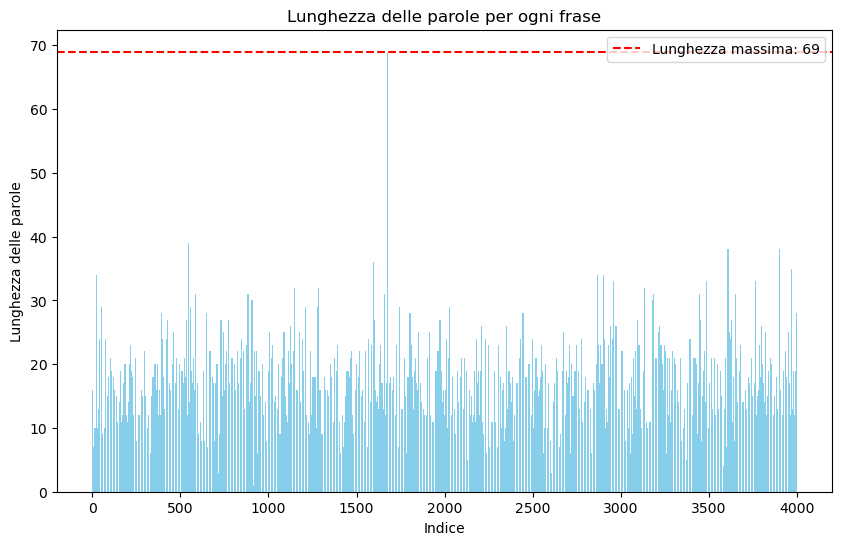

In [53]:
# Calcola la lunghezza di parole per ogni riga nella colonna 'text_column'
df_length = pd.DataFrame()
df_length['word_length'] = df['utterances'].apply(lambda arr: max(len(x.split()) for x in arr))

print(df_length.head())

# Trova la lunghezza massima
max_length = df_length['word_length'].max()

# Crea un grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(df_length.index, df_length['word_length'], color='skyblue')
plt.axhline(y=max_length, color='r', linestyle='--', label=f'Lunghezza massima: {max_length}')
plt.xlabel('Indice')
plt.ylabel('Lunghezza delle parole')
plt.title('Lunghezza delle parole per ogni frase')
plt.legend()
plt.show()

   total_word_length
0                 41
1                 57
2                 88
3                115
4                 30
max length: 263


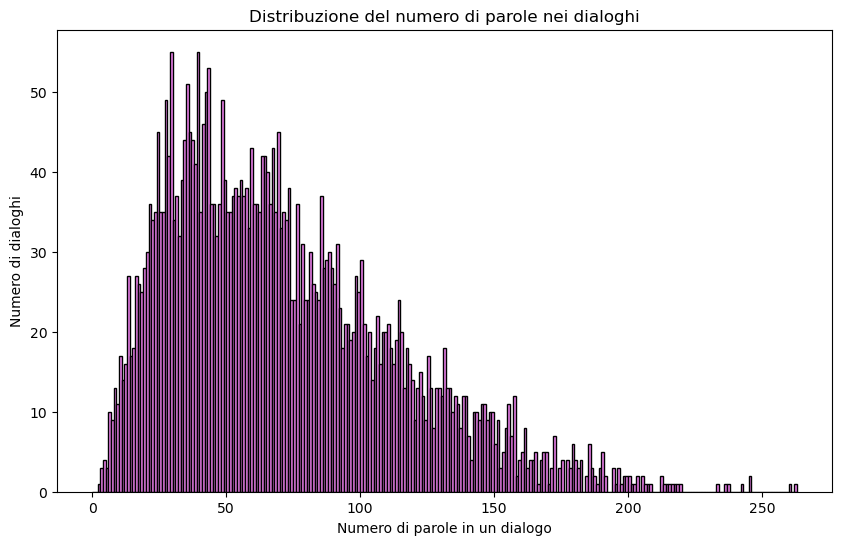

In [52]:
# Calcola la lunghezza di parole per ogni riga nella colonna 'text_column'
df_length = pd.DataFrame()
df_length['total_word_length'] = df['utterances'].apply(lambda arr: sum(len(x.split()) for x in arr))

# Trova la lunghezza massima
max_length = df_length['total_word_length'].max()
print(f"max length: {max_length}")

# Crea un istogramma
plt.figure(figsize=(10, 6))
plt.hist(df_length['total_word_length'], bins=range(0, df_length['total_word_length'].max() + 1, 1), color='violet', edgecolor='black')
plt.xlabel('Numero di parole in un dialogo')
plt.ylabel('Numero di dialoghi')
plt.title('Distribuzione del numero di parole nei dialoghi')
plt.show()

Non mi fido che questo calcolo sia corretto 

In [55]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 270 #da ricontrollare la lunghezza massima
BATCH_SIZE = 1 #richiesta dal prof se non sbaglio

In [54]:
#definizione del dataset per BERT
class BERTDataset(Dataset):

    def __init__(self, utterances, tokenizer, max_len):
        self.row = utterances
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.row)
    
    def __getitem__(self, index):
        sentence = self.row.iloc[index]
        utterance = sentence["utterances"]
        emotions = sentence["emotions"]
        triggers = sentence["triggers"]
        target_emotion = emotions_encoded_dict[emotions]
        target_trigger = triggers_encoded_dict[triggers]

        encoding = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True, 
        )

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        token_type_ids = encoding["token_type_ids"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_emotion": torch.tensor(target_emotion, dtype=torch.float),
            "target_trigger": torch.tensor(target_trigger, dtype=torch.float),
        }

In [56]:
bert_train_dataset = BERTDataset(df_train, tokenizer, MAX_LENGTH)
bert_test_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)
bert_val_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)

train_loader= DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True) #ricontrollare se shuffle deve essere true o false
test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [58]:
#definizione del modello BERT
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(self.l1.config.hidden_size, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(self.l1.config.hidden_size, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return output_emotions, output_trigger

In [59]:
model_name = 'bert-base-uncased'

full_model = BERTClass(model_name)

freezed_model = BERTClass(model_name)
# IMPLEMENTAZIONE DELLA FREEZED VERSION CON I PESI CONGELATI
for param in freezed_model.l1.parameters():
    param.requires_grad = False

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Da fare d'ora in poi:
- loss function
- evaluation/validation functions 
- train function 
- train effettivo sul train set e validation su val set
- metrics su test set
- conclusions